In [11]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import os
import Parameters as Para
para = Para.Parameters(data_size=96,predict_size=12,epochs=20,node_size=32,split_rate=0.7)
city = 'wulumuqi'

In [12]:
def get_correlation(a_list,b_list):
    return np.corrcoef(np.vstack((np.array(a_list),np.array(b_list))))

In [13]:
import getDataset as getDataset
input_data = list()
input_label = list()
# dataset_2016 = getDataset.GetDataset(year=2016, step=72, batch_size=64, data_size=data_size, predict_size=predict_size,split_rate=1)
dataset_2017 = getDataset.GetDataset(year=2017, step=48, batch_size=64, data_size=para.data_size, predict_size=para.predict_size,split_rate=1,city=city)
main_dataset = getDataset.GetDataset(year=2018, step=48, batch_size=64, data_size=para.data_size, predict_size=para.predict_size,split_rate=para.split_rate,city=city)
# data_mean_16, data_std_16 = train_dataset_2016.get_mean_std()
data_mean_17, data_std_17 = dataset_2017.get_mean_std()
data_mean, data_std = main_dataset.get_mean_std()
print(data_mean,data_std)

56.35375118708452 57.827218130986495


In [14]:
# for data1, data2 in dataset_2016.train_dataset():
#     for var in data1:
#         input_data.append(var)
#     for var in data2:
#         input_label.append(var*data_std_16+data_mean_16)      
for data1, data2 in dataset_2017.train_dataset():
    for var in data1:
        input_data.append(var)
    for var in data2:
        input_label.append(var*data_std_17+data_mean_17)         
for data1, data2 in main_dataset.train_dataset():
    for var in data1:
        input_data.append(var)
    for var in data2:
        input_label.append(var*data_std+data_mean)         

In [15]:
print(para.train_size,para.features)
current_data = np.reshape(np.array(input_data), (-1, para.train_size, para.features))
current_label = np.reshape(np.array(input_label), (-1, para.predict_size, 1))

validate_data = list()
validate_label = list()
count = 0
for data1, data2 in main_dataset.test_dataset():
    if count<para.validate_num:
        for var in data1:
            validate_data.append(var)
        for var in data2:
            validate_label.append(var*data_std+data_mean)
    else:
        break
    count+=1
validate_data = np.reshape(np.array(validate_data), (-1, para.train_size, para.features))
validate_label = np.reshape(np.array(validate_label), (-1, para.predict_size, 1)) 

84 15


In [16]:
class SeqToSeq(k.Model):
    def __init__(self,encoder_units, decoder_units, predict_size, time_size):
        """
        :param encoder_units: 
        :param decoder_units: 
        :param predict_size: 
        :param time_size: 
        """
        super(SeqToSeq, self).__init__()
        self.encoder_units = encoder_units
        self.predict_size = predict_size
        self.decoder_units = decoder_units
        self.time_size = time_size
        self.encoder = k.layers.LSTM(self.encoder_units,
                                return_sequences=True,
                                return_state=True,
                                     kernel_regularizer=tf.keras.regularizers.l2(para.l2_rate),
                                     name = 'encoder')
        self.decoder = k.layers.LSTM(self.decoder_units,
                                     return_sequences=True,
                                return_state=True,
                                     kernel_regularizer=tf.keras.regularizers.l2(para.l2_rate),
                                     name = 'decoder')   
        self.dec_fc = k.layers.Dense(para.features,kernel_initializer='glorot_uniform',
                                     kernel_regularizer=tf.keras.regularizers.l2(para.l2_rate),name = 'output',use_bias=False)
        self.output_fc = k.layers.Dense(decoder_units,kernel_initializer='glorot_uniform',
                                     kernel_regularizer=tf.keras.regularizers.l2(para.l2_rate),name = 'output',use_bias=False)

    def call(self, inputs, training=None, mask=None):
        # 获得编码器隐藏状态，编码器细胞状态
        # 编码器的所有输出
        dec_output_list_13 = list()
        inputs = tf.cast(inputs,tf.float32)
        output,enc_h_state_input,enc_c_state_input= self.encoder(inputs)
        # 给解码器的隐藏状态和细胞状态赋初值
        # 用全0向量初始化
        input_value = tf.zeros(tf.shape(inputs[:,-1:,:]))
        for step in range(self.predict_size):
            enc_output, enc_h_state_input, enc_c_state_input = self.decoder(initial_state=[enc_h_state_input,enc_c_state_input],inputs = input_value)
            input_value = self.dec_fc(enc_output)
            # output_value = self.output_fc(dec_output)
            dec_output_list_13.append(input_value[:,:,1:2]*data_std+data_mean)
        dec_output_list_13 = tf.transpose(tf.squeeze(tf.convert_to_tensor(dec_output_list_13),axis=2),[1,0,2])
        return dec_output_list_13

In [17]:
seq_to_seq_sample = SeqToSeq(encoder_units=para.node_size, decoder_units=para.node_size, predict_size=para.predict_size, time_size = para.data_size)
inputs = tf.keras.Input(shape=(para.train_size, para.features))
x_input = tf.keras.layers.BatchNormalization(input_shape=(para.train_size,para.features))(inputs)
output_ = tf.cast(seq_to_seq_sample(x_input),tf.float32)
autoEncoder = tf.keras.Model(inputs=inputs, outputs=output_)
autoEncoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.mean_absolute_error,
                    metrics=[tf.keras.metrics.mean_absolute_percentage_error])
# checkpoint = tf.keras.callbacks.ModelCheckpoint('D:/python_enviroments/Tensorflow_New_Enviroment/paper/checkpoint', monitor='val_acc', verbose=0, save_best_only=False, mode='min', period=5)
# log_dir = 'D:/python_enviroments/Tensorflow_New_Enviroment/paper/log'
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
# callback_lists=[checkpoint]
autoEncoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 15)]          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 15)            60        
_________________________________________________________________
seq_to_seq_1 (SeqToSeq)      (None, 12, 1)             12768     
Total params: 12,828
Trainable params: 12,798
Non-trainable params: 30
_________________________________________________________________


In [18]:
# 100轮
autoEncoder.fit(epochs=para.epochs,x= tf.convert_to_tensor(current_data,dtype=tf.float32), y=tf.convert_to_tensor(current_label,tf.float32), validation_data=[validate_data,validate_label],  batch_size=64)#,callbacks=callback_lists)

Train on 11008 samples, validate on 15 samples
Epoch 1/20
11008/11008 [==============================] - 27s 2ms/sample - loss: 17.9413 - mean_absolute_percentage_error: 43.9460 - val_loss: 9.3444 - val_mean_absolute_percentage_error: 41.3250

[[1.         0.53760052]
 [0.53760052 1.        ]]


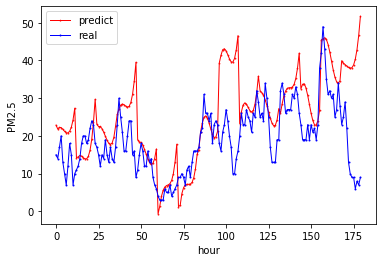

In [19]:
import matplotlib.pyplot as plt
result_dir = "D:/python_enviroments/Tensorflow_New_Enviroment/paper/论文实验部分/Result/"+city+"/predict_size_"+str(para.predict_size)+"/"
file_name = "Pure encoder decoder"
import matplotlib.pyplot as plt
# 连续化的对比图
final_data = main_dataset.final_data(para.validate_num)
real = final_data[para.train_size:].T[1].T
predict = list()
for index_var in range(para.validate_num):
    y = autoEncoder.predict(x=np.reshape(final_data[para.predict_size*index_var:para.predict_size*index_var+para.train_size],(-1,para.train_size,para.features)))
    y = np.reshape(y,(-1,))
    predict.append(y)
predict = np.reshape(np.array(predict),(-1,))
plt.plot(np.arange(0,len(predict)),predict,linewidth= 1,color = 'r', marker = '^',markersize=1)
plt.plot(np.arange(0,len(real)),real*data_std+data_mean,linewidth= 1,color = 'b', marker = 'o',markersize=1)
plt.xlabel('hour')
plt.ylabel('PM2.5')
plt.legend(['predict','real'])
plt.savefig(result_dir+str(para.node_size)+'/'+str(para.node_size)+ file_name+' prediction.png')
print(get_correlation(predict,real))

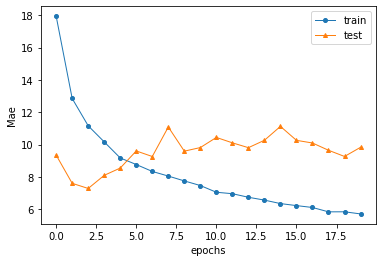

In [20]:
# 设置checkpoint  
plt.plot(np.arange(0,len(autoEncoder.history.history['loss'])),autoEncoder.history.history['loss'],marker = 'o',linewidth = 1,markersize = 4)
plt.plot(np.arange(0,len(autoEncoder.history.history['val_loss'])),autoEncoder.history.history['val_loss'],marker = '^', linewidth = 1,markersize = 4)
plt.xlabel('epochs')
plt.ylabel('Mae')
plt.legend(['train', 'test'])
plt.savefig(result_dir+str(para.node_size)+'/'+str(para.node_size)+str(para.predict_size) +' loss.png')



